# Semantic segmentation
В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>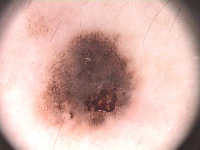</td><td>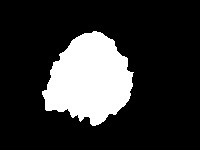</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-11-27 20:49:36--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-11-27 20:49:37--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e8f9803db32a43abced86c77b.dl.dropboxusercontent.com/cd/0/inline/BxnnVnliZZl0L2awVYlF2JGZtP7gdAF0Tb9nY5oGBO8hv3-qP48F207AeluGOVEbJnXamI5NBi-p_NZrEAdHKZ3Rh0z558yoMmBw5tGbu9EjXIr9fezhEVgpRbM_e_xPYkyiu2aXArVbBh5Afme6zOfBz0n_QW-DxrmrGzIBe3yEeQ/file# [following]
--2022-11-27 20:49:38--  https://uc8e8f9803db32a43abced86c77b.dl.dropboxusercontent.com/cd/0/inline/BxnnVnliZZl0L2awVYlF2JGZtP7gdAF0Tb9nY5oGBO8hv3-qP48F207AeluGOVEbJnXamI5

In [2]:
!ls

PH2Dataset.rar	sample_data


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

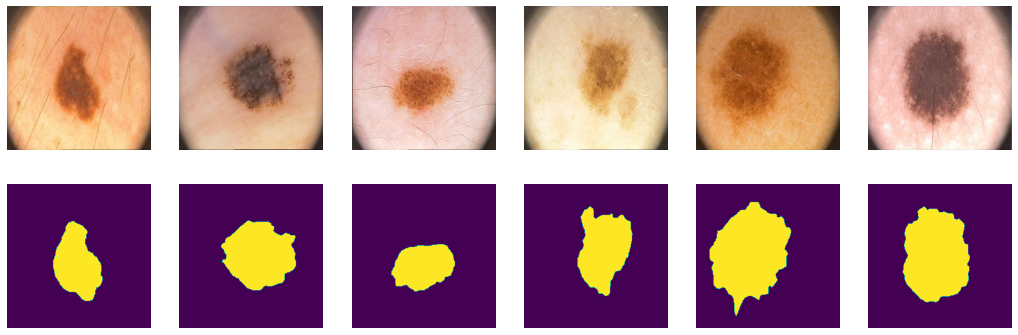

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
import torch
torch.manual_seed(42)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

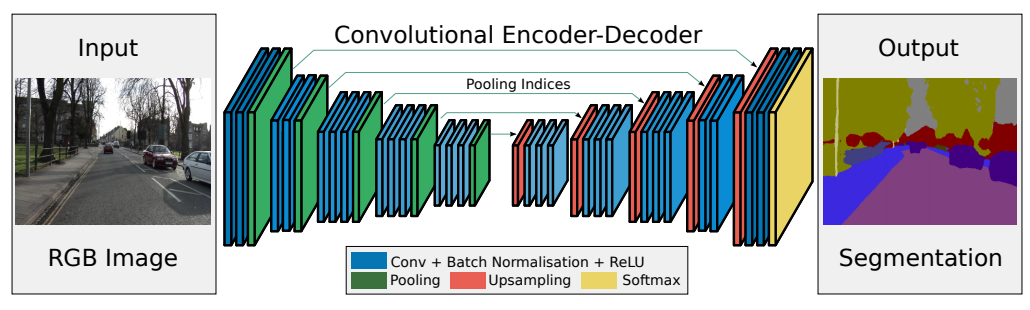

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128  maybe return_indices=True
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
def bce_loss(y_real, y_pred):
    ls = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return ls.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его. Добавим в функцию train вывод промежуточных лоссов на валидационной выборке и score на valid и test. Также в процессе обучения будем сохранять максимальный score на valid выборке и модель с лучшим скором на valid части считать за лучшую.

In [17]:
def train(model, optim, loss_fn, epochs, data_tr, data_val, data_ts, metric):
    X_val, Y_val = next(iter(data_val))

    history = []

    best_val_score = 0
    best_train_score = 0
    best_test_score = 0

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode

        torch.cuda.empty_cache()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # data to device

            optim.zero_grad()  # set parameter gradients to zero
            Y_pred = model(X_batch)  # forward
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            optim.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        train_score = score_model(model, metric, data_tr)
        
        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()    # detach and put into cpu
            Y_pred = model(X_val.to(device)).detach().cpu()    # detach and put into cpu
            Y_mask = Y_hat > 0.5
            val_loss = loss_fn(Y_val, Y_pred)
            val_score = score_model(model, metric, data_val)
            test_score = score_model(model, metric, data_ts)

        history.append((train_score, val_score, val_loss))

        # save best scores on val
        if val_score > best_val_score:
            best_train_score = train_score
            best_val_score = val_score
            best_test_score = test_score

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k, 0].numpy(), cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_mask[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return history, best_train_score, best_val_score, best_test_score

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    with torch.no_grad():
        scores = 0
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

Добавим функцию для отрисовки результатов.

In [20]:
def plot(history, title):
    train_score, val_score, val_loss = zip(*history)

    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 18))
    ax[0].plot(train_score, label="train_score")
    ax[0].plot(val_score, label="val_score")
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("score")
    ax[0].set_title(f'{title}')
    
    ax[1].plot(val_loss, label="val_loss")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("loss")
    ax[1].set_title(f'{title}')

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


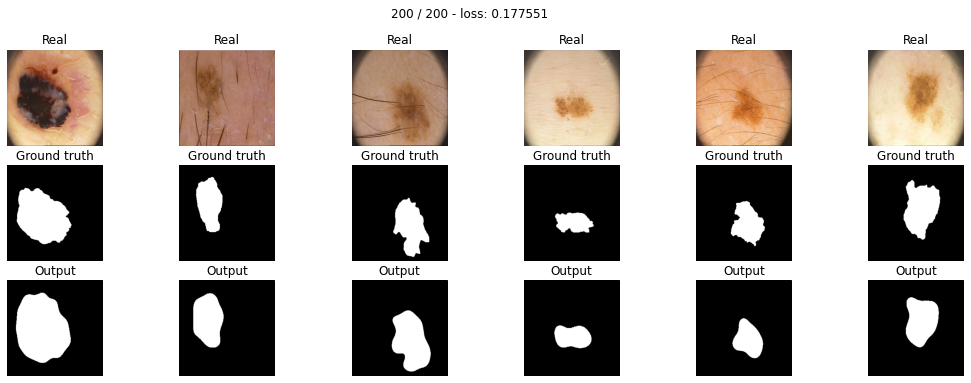

In [ ]:
model_bce = SegNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(model_bce.parameters())
history_segnet_bce, train, val, test = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.9070000052452087
Score on val : 0.7539999783039093
Score on test : 0.7620300026226045


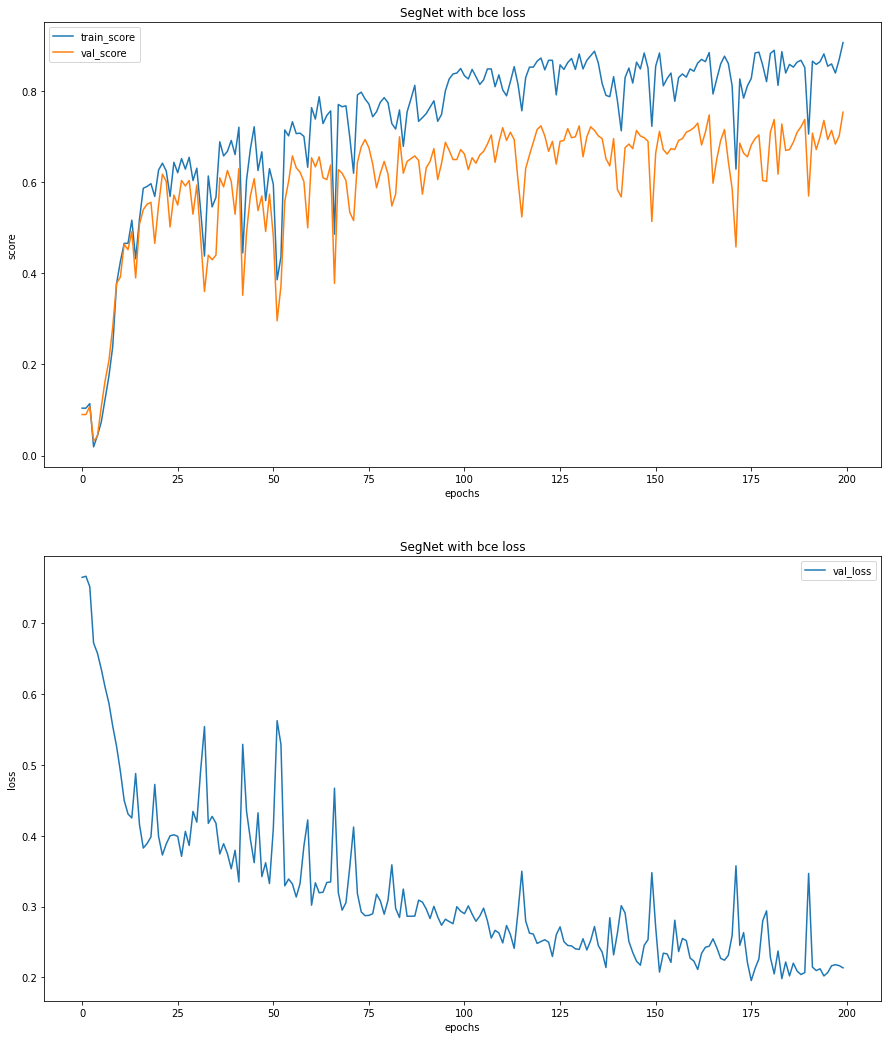

In [ ]:
plot(history_segnet_bce, 'SegNet with bce loss')

Ответьте себе на вопрос: не переобучается ли моя модель?
Модель явно переобучается, о чем свидетельствует большая разница между скором на valid и train частях. Заметим, что модель обучается достаточно шумно (так как шумный график лосса).

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    outputs = torch.sigmoid(y_pred).squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = y_real.squeeze(1)    

    i = (outputs * labels).sum()
    s = (outputs + labels).sum()
    res = 1 - ((2. * i + SMOOTH) / (s + SMOOTH))#/(256*256)
    return res

Проводим тестирование:

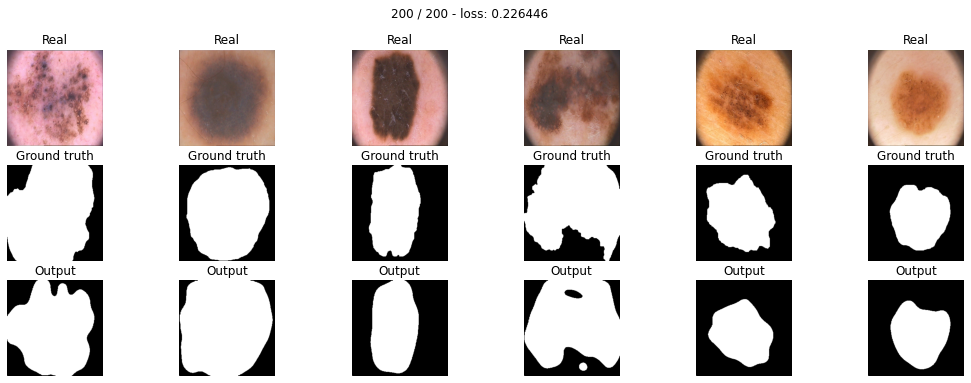

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 200
optimaizer = torch.optim.AdamW(model_dice.parameters())
history_segnet_dice, train, val, test = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.8729999512434006
Score on val : 0.7720000147819519
Score on test : 0.7899999618530273


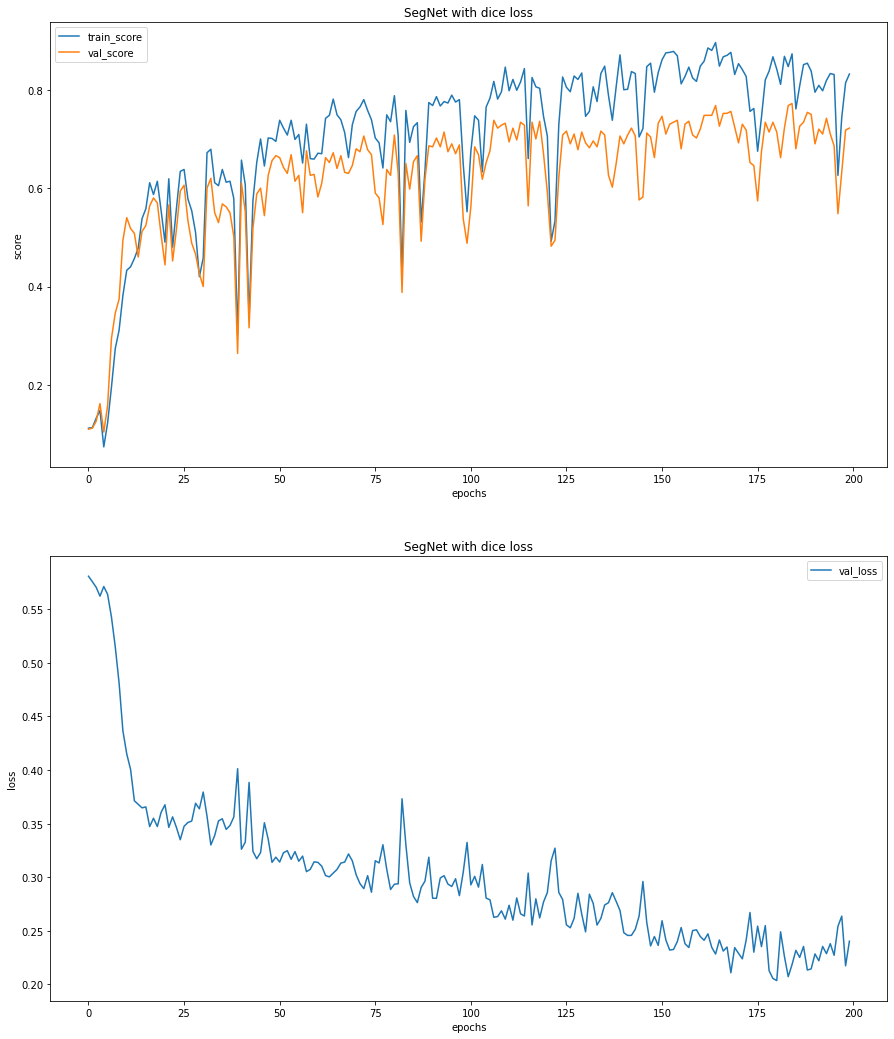

In [ ]:
plot(history_segnet_dice, 'SegNet with dice loss')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, SMOOTH = 1e-8, gamma = 2):
    y = torch.sigmoid(y_pred)+SMOOTH
    loss = -((1-y)*(1-y)*y_real*torch.log(y)+(1-y_real)*torch.log(1-y))
    
    return loss.mean()

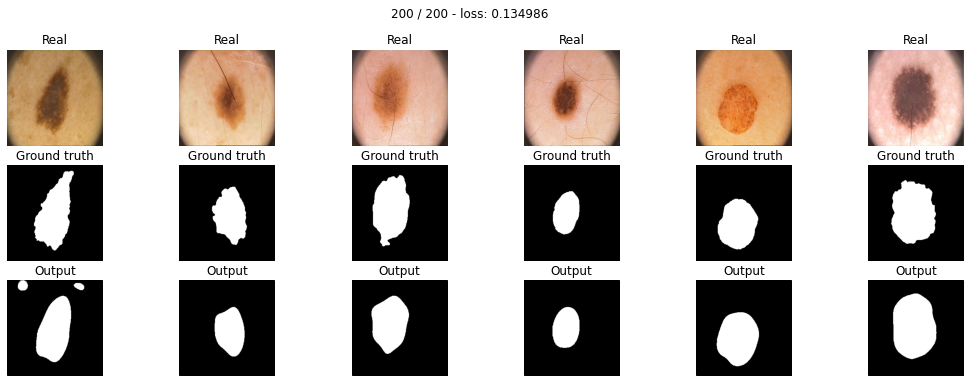

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 200
optimaizer = torch.optim.AdamW(model_focal.parameters())
history_segnet_focal, train, val, test = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.863999992609024
Score on val : 0.7339999377727509
Score on test : 0.7119999825954437


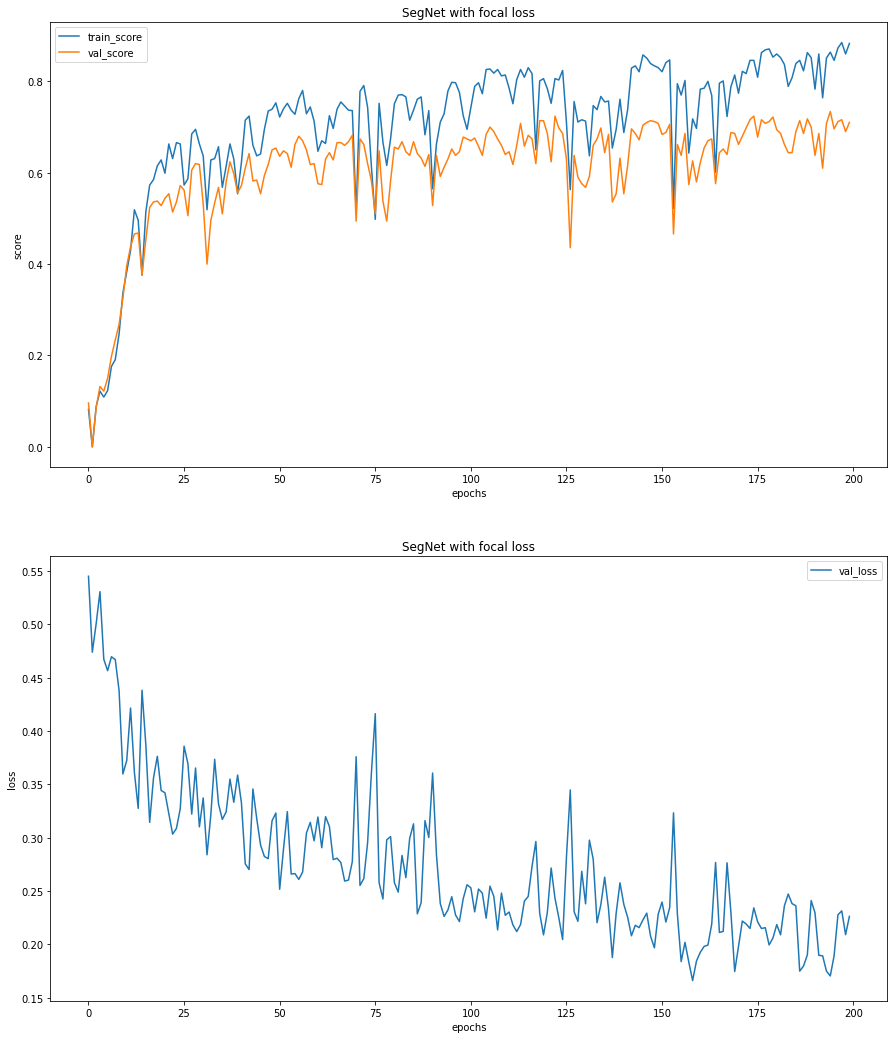

In [ ]:
plot(history_segnet_focal, 'SegNet with focal loss')

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### 3)Focal loss with Total Variation 

Total Variation основан на принципе, что выход модели с чрезмерными и, возможно, ложными деталями имеет высокую общую вариацию. Поэтому достаточно логичная идея - ругать модель за слишком большую разницу значений в соседних пикселях изображения. По идее, при учете total variation удаляются ненужные детали, сохраняя при этом важные особенности, такие как края.

Воплотить эту идею в жизнь поможет математика. Предлагается в качестве добавочного члена к обычному сегментационному лоссу(в моем случае - focal) использовать лосс totalvariation:

$$\mathcal L_{totvar}(\hat y) = \sum_{i, j} [(\hat y_{i + 1, j} - \hat y_{i, j})^2 + (\hat y_{i, j+1} - \hat y_{i, j})^2]$$

В итоге, суммарный лос (в моем случае β=0.5):
$$\mathcal L_{foctot}(y, \hat y) = \mathcal L_{focal}(y, \hat y) + β⋅\mathcal L_{totvar}(\hat y)$$


In [21]:
def total_variation_loss(y_real, y_pred, beta=0.5):
    y = torch.sigmoid(y_pred)
    bs, c, h, w = y.size()
    tv_h = torch.pow(y[:,:,1:,:] - y[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(y[:,:,:,1:] - y[:,:,:,:-1], 2).sum()

    loss = -((1-y)*(1-y)*2*y_real*torch.log(y)+(1-y_real)*torch.log(1-y))

    return beta*(tv_h + tv_w) / (bs*c*h*w) + loss.mean()

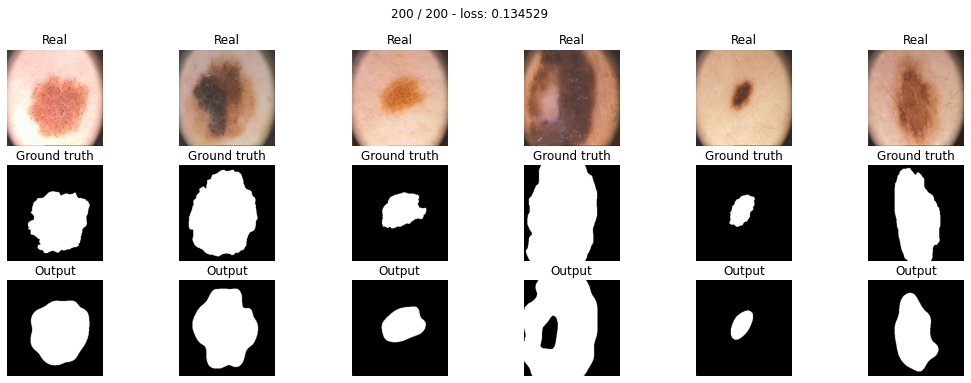

In [ ]:
model_focal_totalvar = SegNet().to(device)

max_epochs = 200
optimaizer = torch.optim.AdamW(model_focal_totalvar.parameters())
history_segnet_focal_totalvar, train, val, test = train(model_focal_totalvar, optimaizer, \
                                                        total_variation_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.8960000276565552
Score on val : 0.7700000107288361
Score on test : 0.7499999701976776


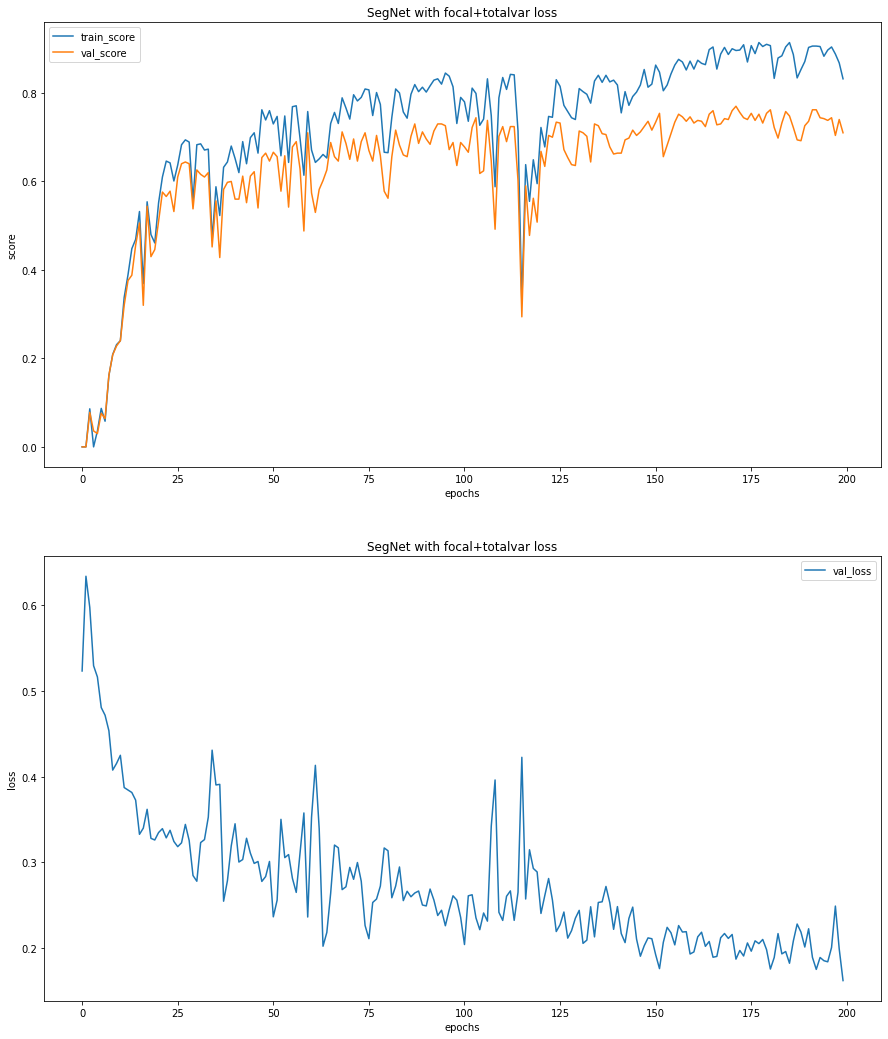

In [ ]:
plot(history_segnet_focal_totalvar, 'SegNet with focal+totalvar loss')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

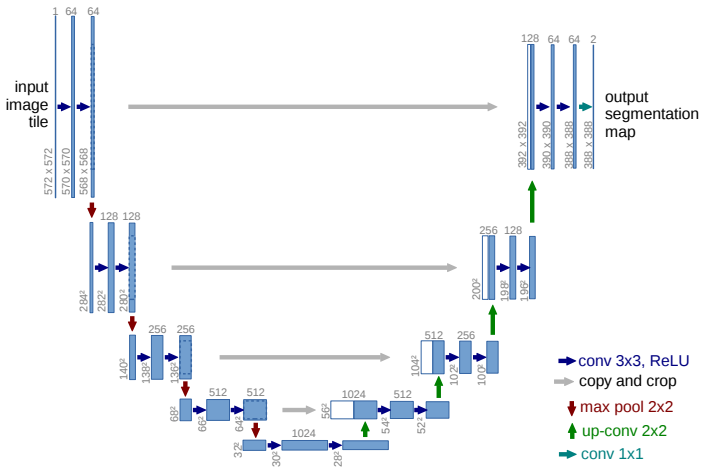

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128  maybe return_indices=True
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=2*512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2*256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=2*128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=2*64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0_conv = self.enc_conv0(x)
        e0 = self.pool0(e0_conv)
        e1_conv = self.enc_conv1(e0)
        e1 = self.pool1(e1_conv)
        e2_conv = self.enc_conv2(e1)
        e2 = self.pool2(e2_conv)
        e3_conv = self.enc_conv3(e2)
        e3 = self.pool3(e3_conv)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder 
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3_conv], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2_conv], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1_conv], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0_conv], 1))  # no activation
        return d3

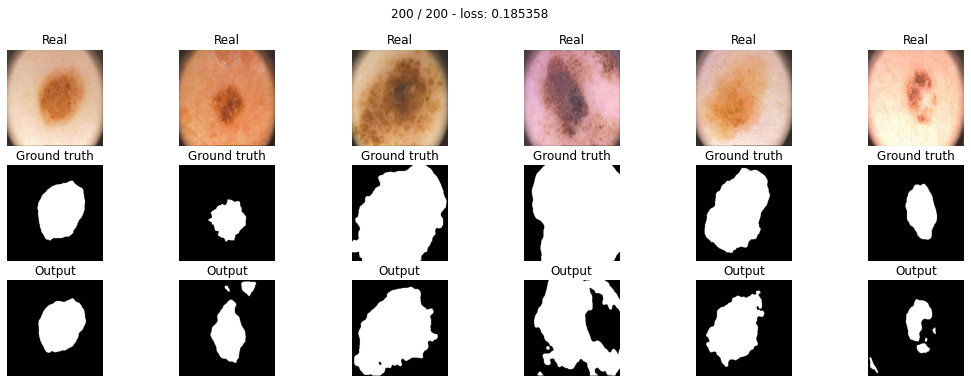

In [ ]:
unet_bce_model = UNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet_bce_model.parameters())
history_unet_bce, train, val, test = train(unet_bce_model, optim, bce_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.892999991774559
Score on val : 0.7479999959468842
Score on test : 0.8219999670982361


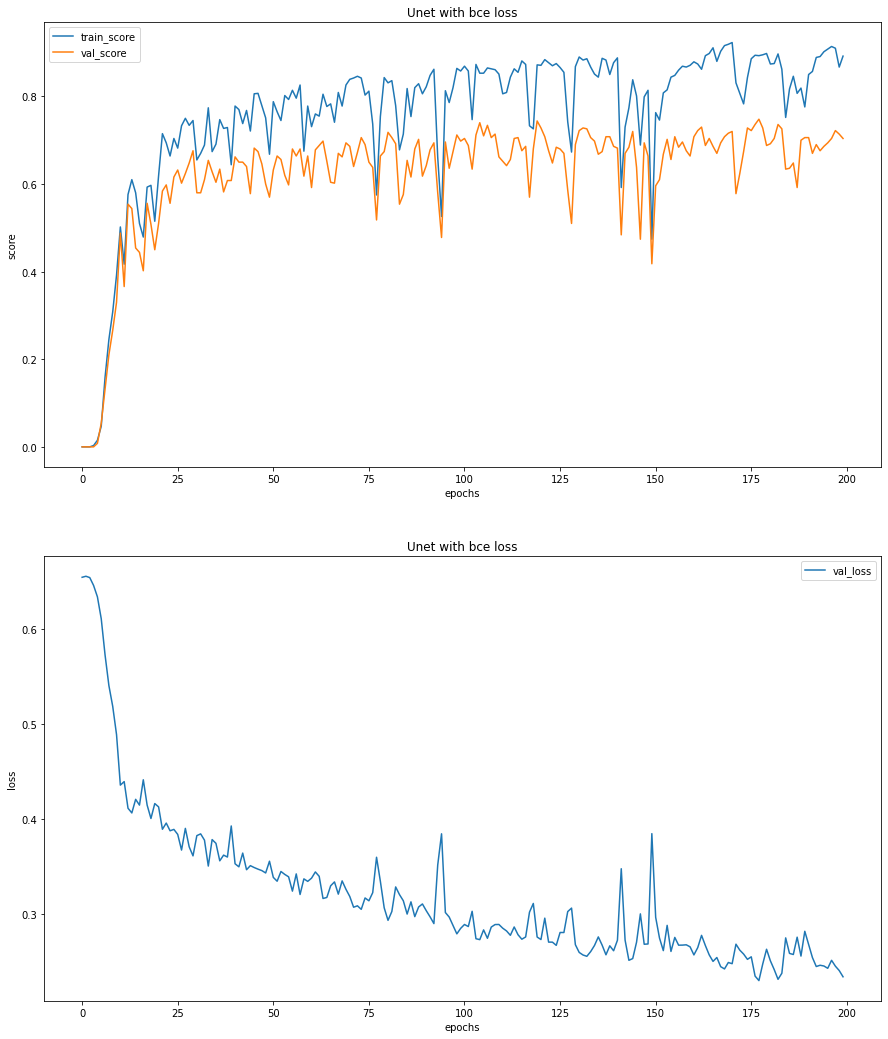

In [ ]:
plot(history_unet_bce, 'Unet with bce loss')

### 1. Dice coefficient:

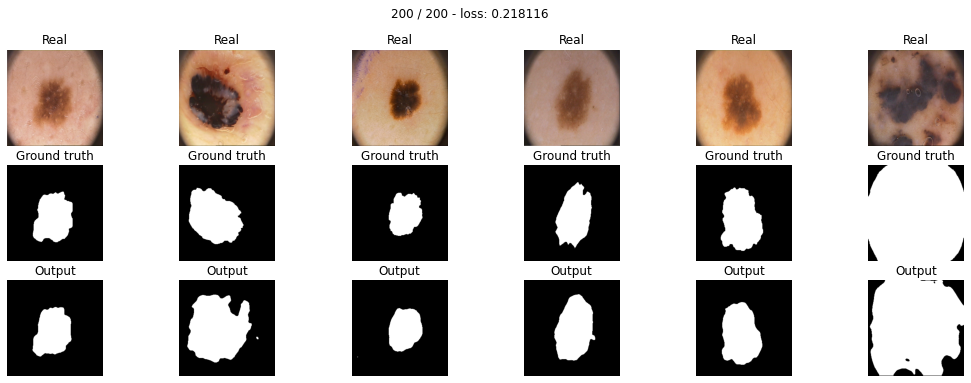

In [ ]:
unet_dice_model = UNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet_dice_model.parameters())
history_unet_dice, train, val, test = train(unet_dice_model, optim, dice_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.9420000463724136
Score on val : 0.777999997138977
Score on test : 0.7860000133514404


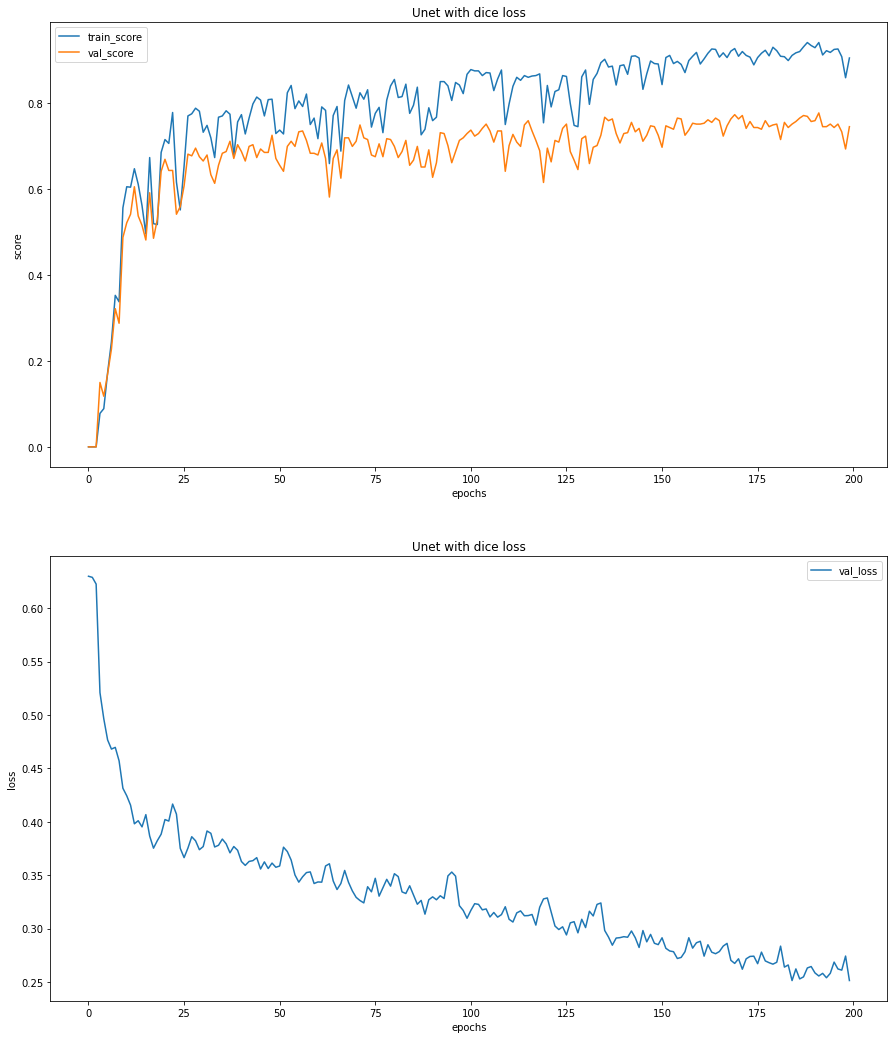

In [ ]:
plot(history_unet_dice, 'Unet with dice loss')

### 2. Focal loss:

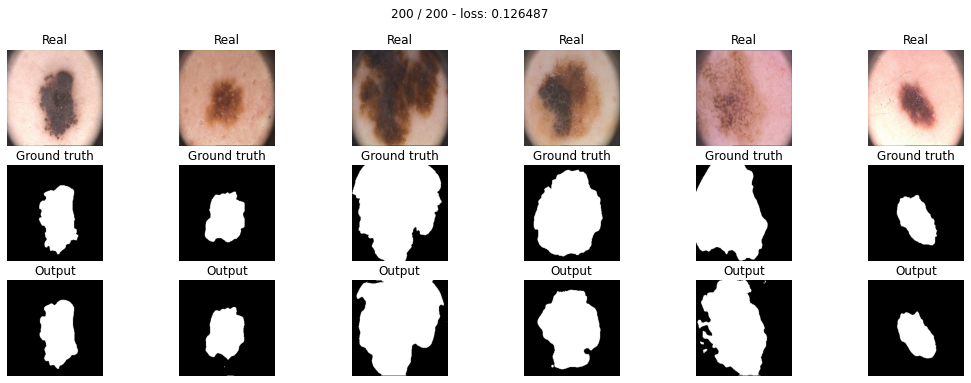

In [ ]:
unet_focal_model = UNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet_focal_model.parameters())
history_unet_focal, train, val, test = train(unet_focal_model, optim, focal_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.9249999970197678
Score on val : 0.792000025510788
Score on test : 0.7519999742507935


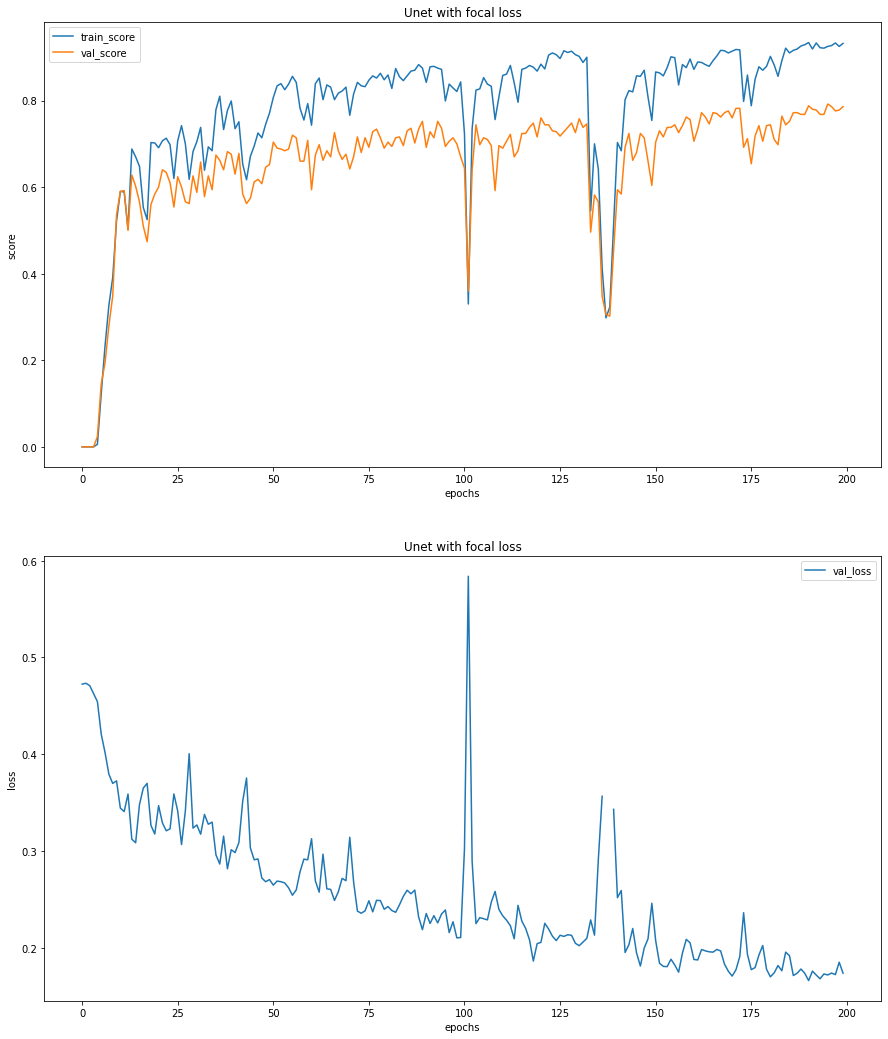

In [ ]:
plot(history_unet_focal, 'Unet with focal loss')

### 3)Focal loss with Total Variation

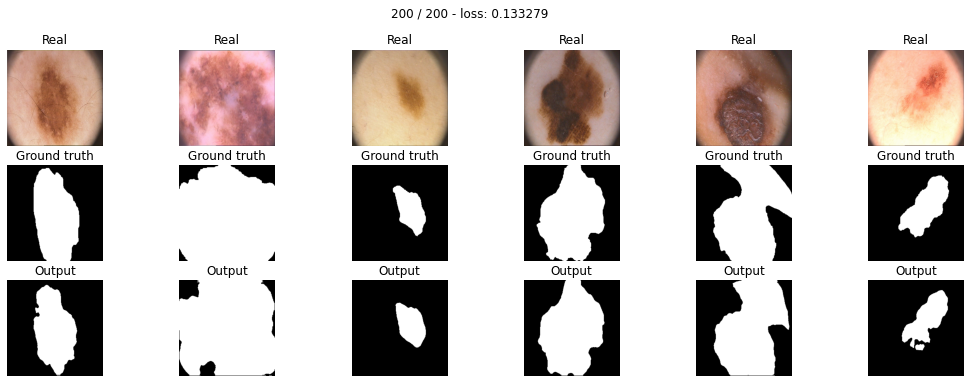

In [ ]:
unet_focal_totalvar_model = UNet().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet_focal_totalvar_model.parameters())
history_unet_focal_totalvar, train, val, test = train(unet_focal_totalvar_model, optim, \
                                                      total_variation_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.9400000423192978
Score on val : 0.820000022649765
Score on test : 0.757999986410141


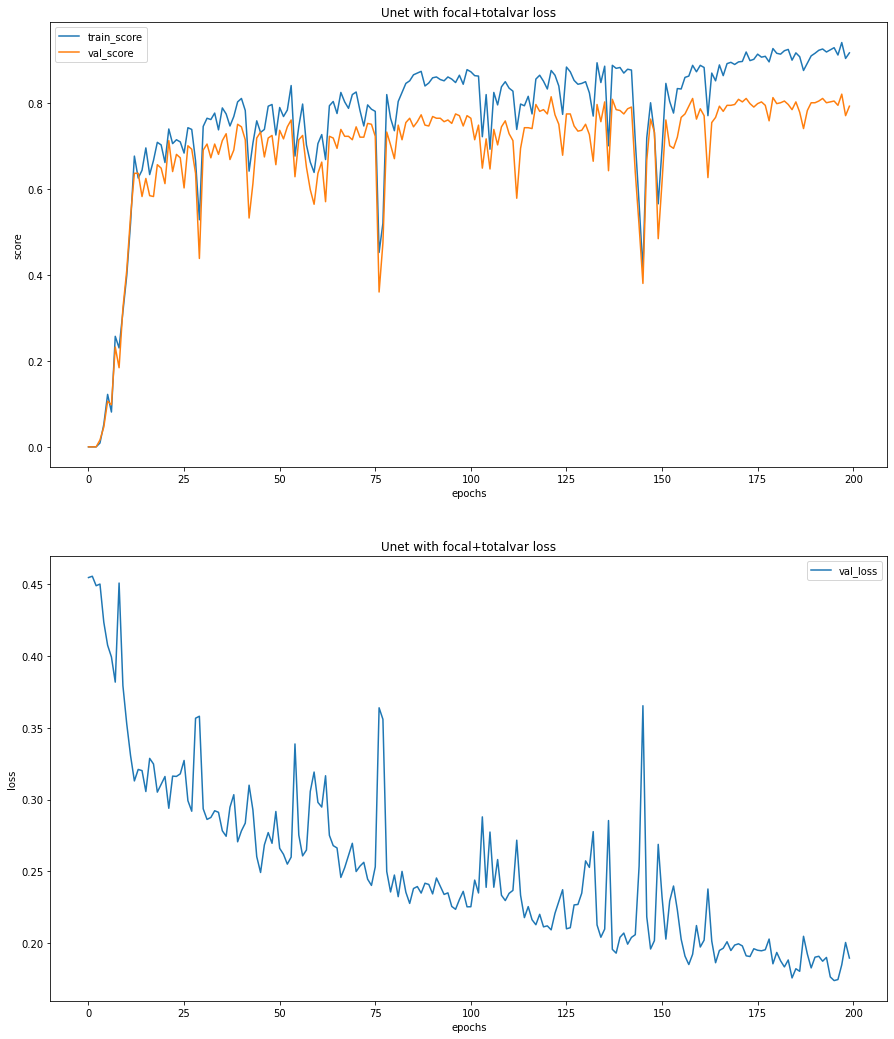

In [ ]:
plot(history_unet_focal_totalvar, 'Unet with focal+totalvar loss')

# UNet2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [22]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)  # 256 -> 128  
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=2*512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2*256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=2*128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=2*64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0_conv = self.enc_conv0(x)
        e0 = self.pool0(e0_conv)
        e1_conv = self.enc_conv1(e0)
        e1 = self.pool1(e1_conv)
        e2_conv = self.enc_conv2(e1)
        e2 = self.pool2(e2_conv)
        e3_conv = self.enc_conv3(e2)
        e3 = self.pool3(e3_conv)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder 
        d0 = self.dec_conv0(torch.cat([self.upsample0(b, output_size=e3_conv.size()), e3_conv], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, output_size=e2_conv.size()), e2_conv], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, output_size=e1_conv.size()), e1_conv], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, output_size=e0_conv.size()), e0_conv], 1))  # no activation
        return d3

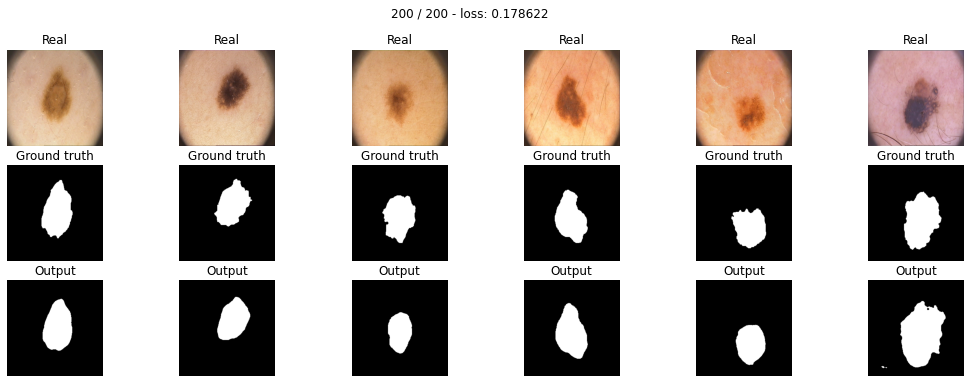

In [ ]:
unet2_bce_model = UNet2().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet2_bce_model.parameters())
history_unet2_bce, train, val, test = train(unet2_bce_model, optim, bce_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.8860000371932983
Score on val : 0.7539999783039093
Score on test : 0.7660000026226044


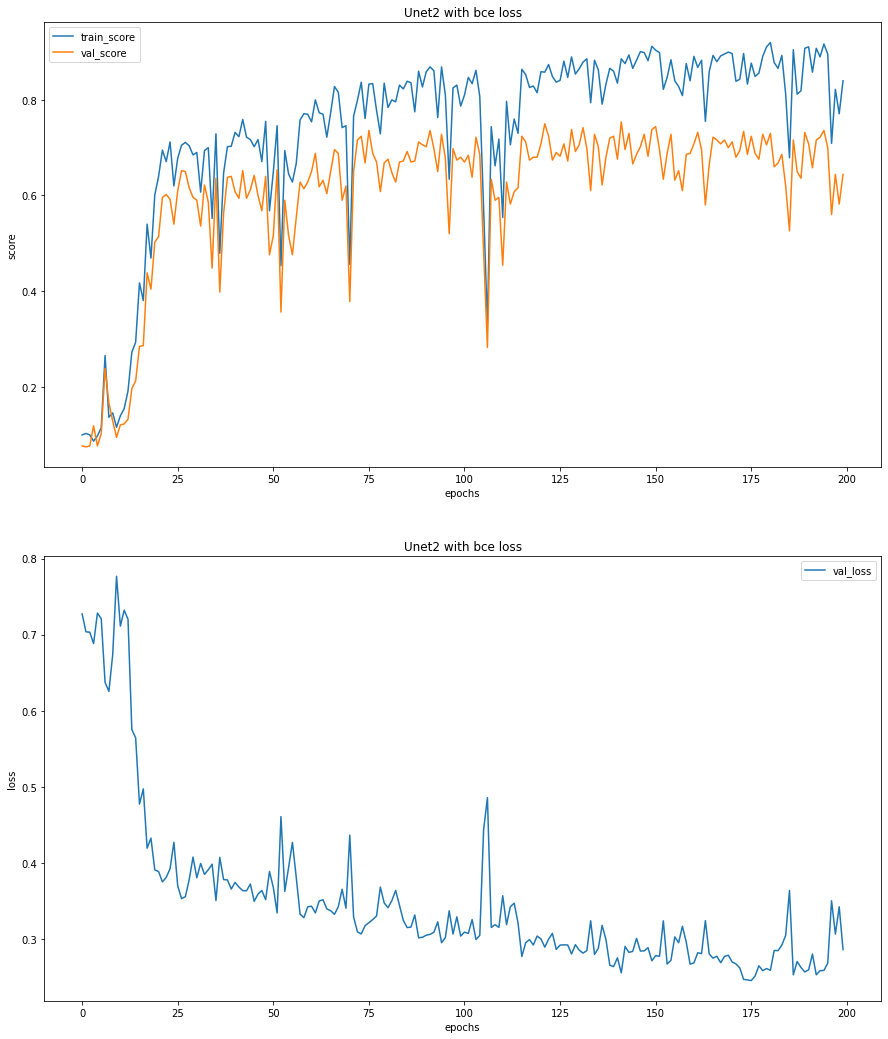

In [ ]:
plot(history_unet2_bce, 'Unet2 with bce loss')

### 1. Dice coefficient:

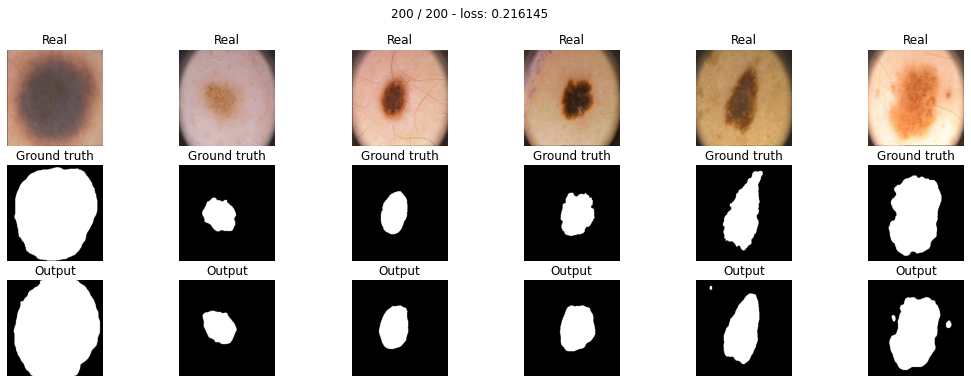

In [ ]:
unet2_dice_model = UNet2().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet2_dice_model.parameters())
history_unet2_dice, train, val, test = train(unet2_dice_model, optim, dice_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.8310000002384186
Score on val : 0.7179999649524689
Score on test : 0.6480000019073486


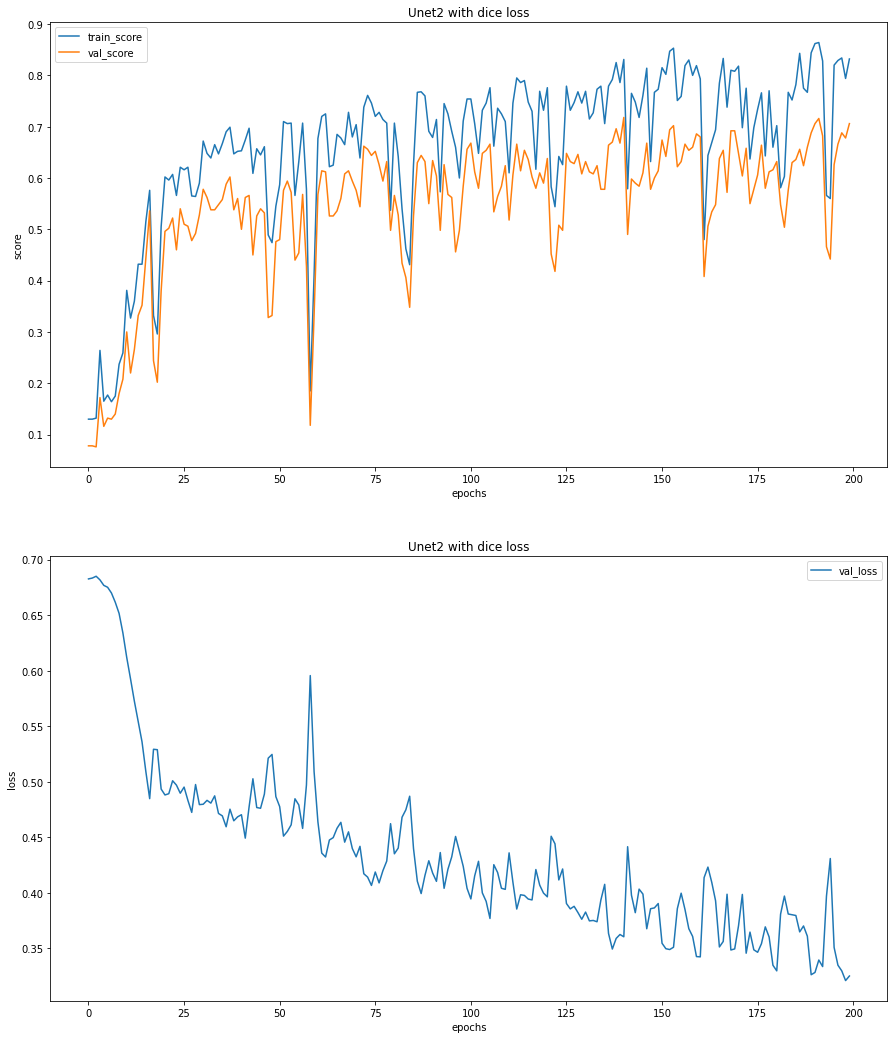

In [ ]:
plot(history_unet2_dice, 'Unet2 with dice loss')

### Focal loss:

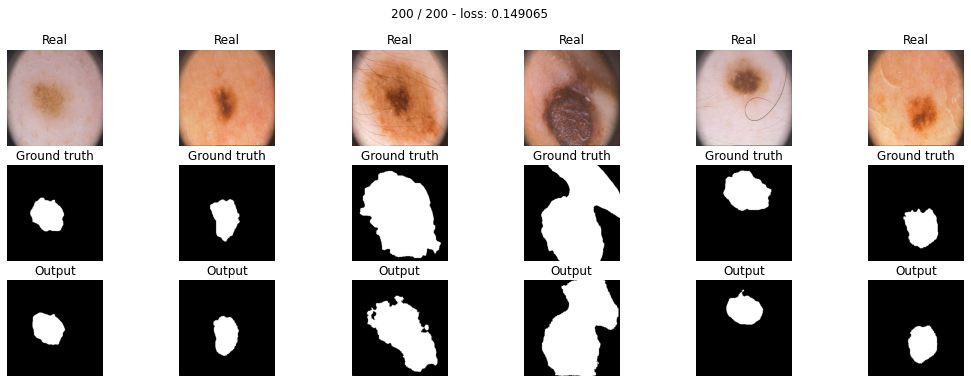

In [ ]:
unet2_focal_model = UNet2().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet2_focal_model.parameters())
history_unet2_focal, train, val, test = train(unet2_focal_model, optim, focal_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.8650000095367432
Score on val : 0.7440000474452972
Score on test : 0.7360000014305115


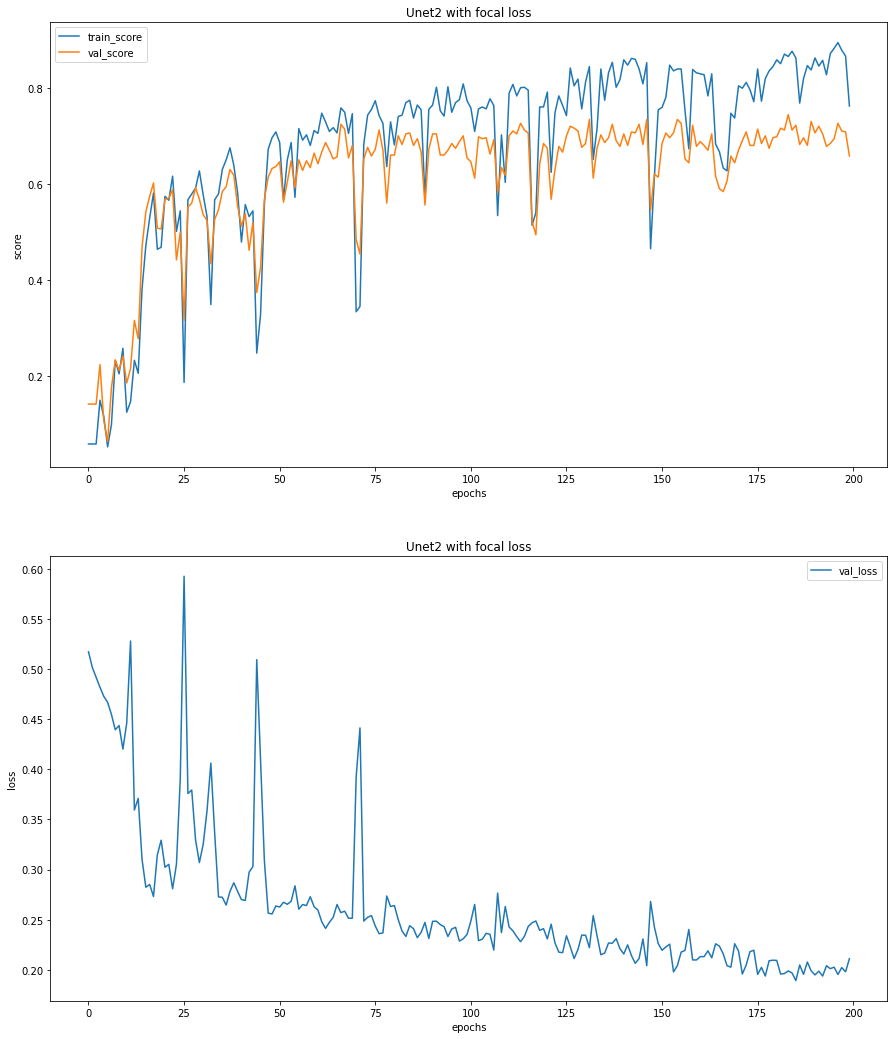

In [ ]:
plot(history_unet2_focal, 'Unet2 with focal loss')

### Focal loss with Total Variation

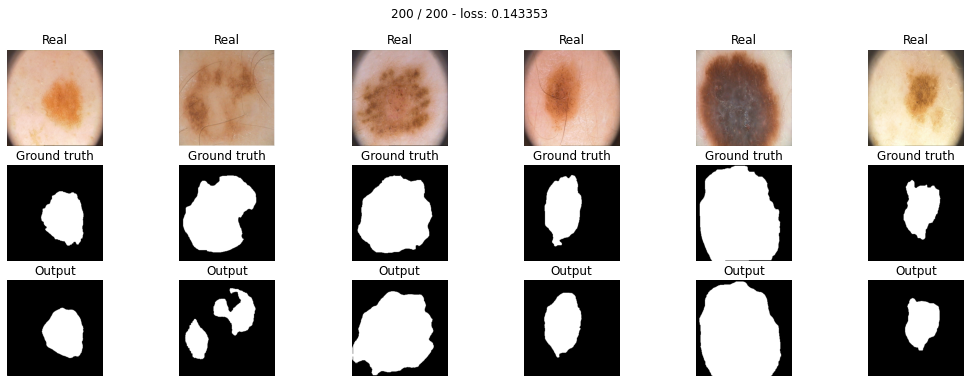

In [23]:
unet2_focal_totalvar_model = UNet2().to(device)

max_epochs = 200
optim = torch.optim.AdamW(unet2_focal_totalvar_model.parameters())
history_unet2_focal_totalvar, train, val, test = train(unet2_focal_totalvar_model, optim, \
                                                       total_variation_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [24]:
print(f'Score on train : {train}')
print(f'Score on val : {val}')
print(f'Score on test : {test}')

Score on train : 0.818000003695488
Score on val : 0.7439999580383301
Score on test : 0.7840000092983246


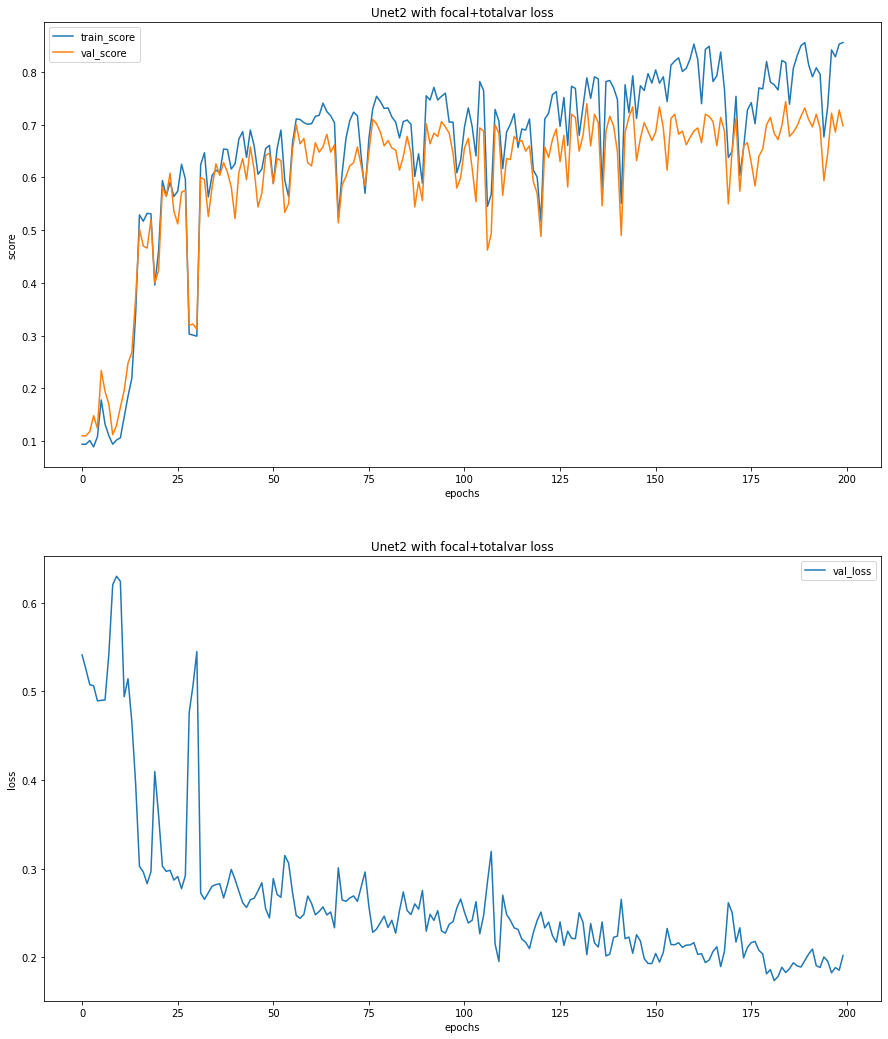

In [25]:
plot(history_unet2_focal_totalvar, 'Unet2 with focal+totalvar loss')

## Сравнение моделей

Для начала сведем метрики всех моделей в единую таблицу.

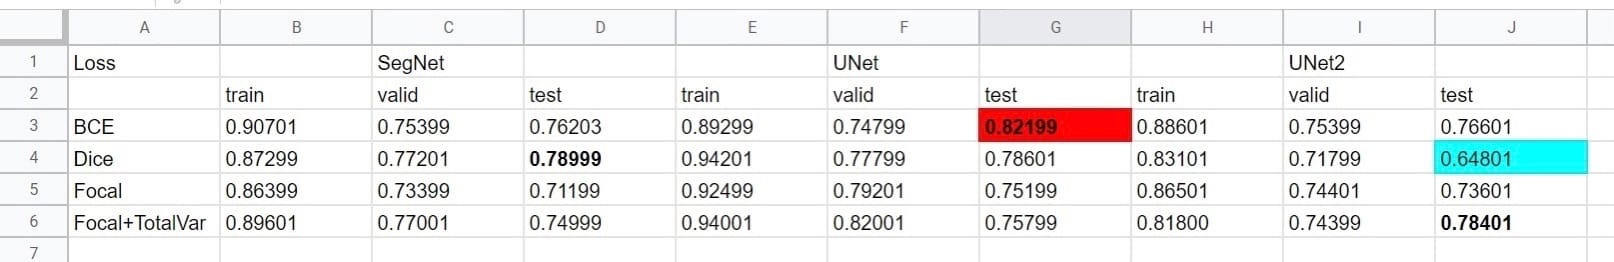

На мой взгляд, сравнивать модели лучше всего по их результатам на тестовой выборке. Согласно таблице, лучший результат показала UNet с ВСE лоссом. Худший результат (похожий на выброс) у UNet2 с Dice лоссом (жирным шрифтом в таблице выделены лучшие метрики для каждой модели). 

### Гипотеза 1 - UNet и UNet2 лучше, чем SegNet

Архитектуры UNet и UNet2 первоначально создавались именно для сегментации медицинских изображений, поэтому логично предположить, что они покажут лучший результат, чем SegNet. Для проверки этой гипотезы нужно проверить, что в среднем метрики на тестовой выборке у UNet и UNet2 выше, чем у Segnet. Посчитаем среднее значение test-метрик для каждой модели.  

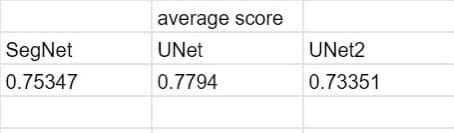

Видно, что модель UNet показала лучший средний результат, однако UNet2 оказалась худшей(опять же, скорее всего это связано с уж совсем низким результатом с Dice лоссом). Поэтому гипотеза верна лишь отчасти. Да и вообще, архитектуры UNet и UNet2 смогли выделить достаточно сложные детали картинки, что может быть важно для задач медицины(см. картинки с groundtruth-output выше).

### Гипотеза 2 - Focal loss лучше BCE

Как уже было отмечено выше, Focal loss - это усовершенствование BinaryCrossEntropy. Заключается оно в том, что мы насильственно уменьшаем вес "простых" примеров (однозначный фон или центр меланомы/родинки), в то время как веса пикселей, в которых модель не уверена(края + сложные детали), возрастают. По идее это должно приводить к тому, что модель должна выучивать более сложные закономерности и давать лучшие результаты. Проверим, так ли это на самом деле. Для этого посчитаем среднее значение тестовых метрик каждой модели отдельно для Focal и BCE лосса.

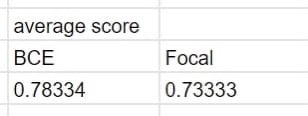

Выдвинутая гипотеза не оправдалась. Но почему?

Скорее всего это связано с маленьким размером датасета. На большом наборе данных мы могли бы дольше обучать модель с Focal лоссом и возможно тогда бы модель и обогнала BCE (тут встает ранее затронутая проблема переобучения - все модели достаточно быстро начинают переобучаться).

### Гипотеза 3 - учет TotalVariation что-то да дает!

Хочется верить, что метрики моделей с логичной для задачи сегментации регуляризацией в виде total variation дадут лучший результат, чем без нее. Для этого можно проверить, что метрики с использованием focal loss с регуляризацией total variation лучше чем просто focal.

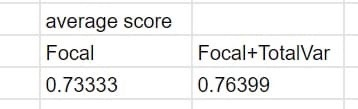

Гипотеза оказалась верной и использование TotalVar себя оправдала.

# Общие выводы и заключительные замечания

В своей работе я опробовал различные архитектуры и функции потерь для задачи сегментации изображений. В общем и целом, удалось обучить каждую представленную архитектуру под все функции потерь. Хочется отметить, что каждая модель достаточно быстро переобучалась из-за маленького набора данных. Обучение моделей было достаточно шумным, а результаты не очень хорошими. Я заметил, что некоторые изображения плохо соответствуют их ground-truth маскам, так что возможно это одна из причин невысокого скора. Что касается времени обучения, то архитектуры SegNet и UNet обучались примерно за одно время (примерно 20 минут), в то время как UNet2 обучалась подольше (30 минут). 